In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

import os
import requests
import zipfile
from pathlib import Path

from PIL import Image
import random
import numpy as np
import matplotlib.pyplot as plt

from typing import Tuple, Dict, List

torch.__version__

'2.4.0'

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [3]:
# Setup path to data folder
data_path = Path("data/")
image_path = data_path / "PCAM_Subset"

# If the image folder doesn't exist, download it and prepare it...
if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)

    # Download pizza, steak, sushi data
    with open(data_path / "PCAM_Subset.zip", "wb") as f:
        request = requests.get("https://github.com/subhajitbn/PCam_Subset/raw/main/data/PCAM_Subset.zip")
        print("Downloading PCAM_Subset data...")
        f.write(request.content)

    # Unzip pizza, steak, sushi data
    with zipfile.ZipFile(data_path / "PCAM_Subset.zip", "r") as zip_ref:
        print("Unzipping PCAM_Subset data...")
        zip_ref.extractall(image_path)

data\PCAM_Subset directory exists.


## 2. Data preparation and exploration

In [4]:
def walk_through_dir(dir_path):
    """
    Walks through dir_path returning its contents.
    Args:
    dir_path (str or pathlib.Path): target directory
    """
    for dirpath, dirnames, filenames in os.walk(dir_path):
        print(
            f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

walk_through_dir(image_path)

There are 2 directories and 0 images in 'data\PCAM_Subset'.
There are 2 directories and 0 images in 'data\PCAM_Subset\test'.
There are 0 directories and 318 images in 'data\PCAM_Subset\test\0'.
There are 0 directories and 337 images in 'data\PCAM_Subset\test\1'.
There are 2 directories and 0 images in 'data\PCAM_Subset\train'.
There are 0 directories and 2596 images in 'data\PCAM_Subset\train\0'.
There are 0 directories and 2647 images in 'data\PCAM_Subset\train\1'.


In [5]:
# Setup train and test dir
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

(WindowsPath('data/PCAM_Subset/train'), WindowsPath('data/PCAM_Subset/test'))

### 2.1. Visualize a few images

Let's write some code to:

1. Get all the image paths.
2. Pick a random image path with Python's random.choice().
3. Get the image class name.
4. Let's open the image with Python's PIL.
5. Show the image metadata.

Image path: data\PCAM_Subset\train\0\2581.jpg
Image class: 0
Image width: 96px
Image height: 96px


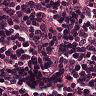

In [6]:
# random.seed(42)

# 1. Get all the image paths
image_path_list = list(image_path.glob("*/*/*.jpg"))

# 2. Pick a random image path
random_image_path = random.choice(image_path_list)

# 3. Get the image class from the path name (the image class is the name of the directory where the image is stored)
image_class = random_image_path.parent.stem

print(f"Image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image width: {Image.open(random_image_path).width}px")
print(f"Image height: {Image.open(random_image_path).height}px")
Image.open(random_image_path)

In [7]:
img_asarray = np.asarray(Image.open(random_image_path))
img_asarray

array([[[ 90,  45,  76],
        [ 86,  41,  72],
        [130,  86, 119],
        ...,
        [ 62,   8,  34],
        [224, 166, 191],
        [162, 100, 125]],

       [[ 63,  18,  49],
        [120,  75, 106],
        [136,  91, 124],
        ...,
        [107,  53,  79],
        [247, 189, 214],
        [165, 103, 128]],

       [[ 75,  28,  60],
        [150, 103, 135],
        [134,  87, 121],
        ...,
        [117,  61,  90],
        [146,  86, 112],
        [255, 198, 225]],

       ...,

       [[ 86,  44,  80],
        [ 32,   0,  26],
        [215, 169, 206],
        ...,
        [ 30,   0,  19],
        [104,  63,  97],
        [ 58,  21,  54]],

       [[100,  61,  92],
        [ 48,   7,  39],
        [111,  66,  99],
        ...,
        [137,  87, 124],
        [109,  68, 102],
        [112,  75, 108]],

       [[ 60,  21,  48],
        [134,  94, 121],
        [156, 113, 141],
        ...,
        [ 72,  22,  60],
        [122,  78, 114],
        [ 95,  58,  92]]

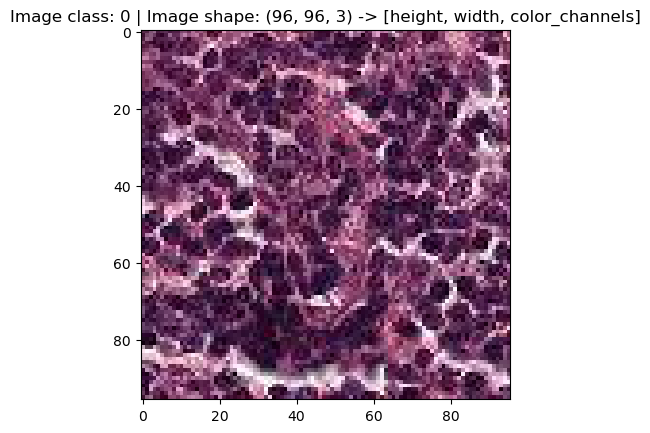

In [8]:
plt.figure()
plt.imshow(img_asarray)
plt.title(f"Image class: {image_class} | Image shape: {img_asarray.shape} -> [height, width, color_channels]")
plt.show()

### 2.2 Transforming data

1. Turn the target data into `torch.Tensor` format.
2. Turn it into a `torch.utils.data.Dataset` and subsequently into `torch.utils.data.Dataloader`. We'll cal these Dataset and Dataloader

In [9]:
data_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

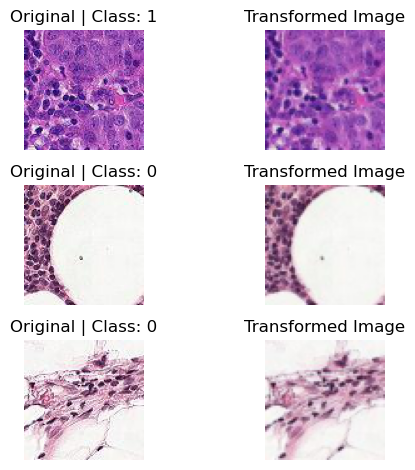

In [10]:
def plot_transformed_images(image_paths, transform, n=3, seed=42):
  """
  Selects n random images from image_paths, transforms them
  with transform and plots the results.
  """
  random.seed(seed)
  random_image_paths = random.sample(image_paths, k=n)

  fig, ax = plt.subplots(n, 2)
  for index, image_path in enumerate(random_image_paths):
    img = Image.open(image_path, 'r')
    ax[index, 0].imshow(img)
    ax[index, 0].set_title(f"Original | Class: {image_path.parent.stem}")
    ax[index, 0].axis("off")

    transformed_image = transform(img).permute(1, 2, 0)
    ax[index, 1].imshow(transformed_image)
    ax[index, 1].set_title(f"Transformed Image")
    ax[index, 1].axis("off")
    plt.tight_layout()

plot_transformed_images(image_path_list, data_transform, n=3)

In [11]:
# Create training transform with TrivialAugment
train_transform_trivial_augment = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor()
])

# Create testing transform (no data augmentation)
test_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])


train_data = datasets.ImageFolder(root=train_dir,
                                    transform=data_transform,
                                    target_transform=None)
test_data = datasets.ImageFolder(root=test_dir,
                                    transform=data_transform)

train_data, test_data

(Dataset ImageFolder
     Number of datapoints: 5243
     Root location: data\PCAM_Subset\train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 655
     Root location: data\PCAM_Subset\test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ))

In [12]:
train_data.classes, test_data.classes

(['0', '1'], ['0', '1'])

In [21]:
BATCH_SIZE = 4
NUM_WORKERS = os.cpu_count()
train_dataloader = DataLoader(dataset=train_data,
                                  batch_size=BATCH_SIZE,
                                  num_workers=NUM_WORKERS,
                                  shuffle=True)
test_dataloader = DataLoader(dataset=test_data,
                                  batch_size=BATCH_SIZE,
                                  num_workers=NUM_WORKERS,
                                  shuffle=False)
len(train_dataloader), len(test_dataloader)

(1311, 164)

In [14]:
class TinyVGG(nn.Module):
    """
    Model architecture copying TinyVGG from:
    https://poloclub.github.io/cnn-explainer/
    """
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int) -> None:
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape,
                      out_channels=hidden_units,
                      kernel_size=3, # how big is the square that's going over the image?
                      stride=1, # default
                      padding=1), # options = "valid" (no padding) or "same" (output has same shape as input) or int for specific number
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2) # default stride value is same as kernel_size
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            # Where did this in_features shape come from?
            # It's because each layer of our network compresses and changes the shape of our input data.
            nn.Linear(in_features=hidden_units*16*16,
                      out_features=output_shape)
        )

    def forward(self, x: torch.Tensor):
        return self.classifier(self.conv_block_2(self.conv_block_1(x))) # <- leverage the benefits of operator fusion

In [15]:
# Create model_1 and send it to the target device
torch.manual_seed(42)
model_1 = TinyVGG(
    input_shape=3,
    hidden_units=10,
    output_shape=len(train_data.classes)).to(device)
model_1

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=2560, out_features=2, bias=True)
  )
)

In [16]:
# 1. Get a batch of images and labels from the DataLoader
img_batch, label_batch = next(iter(train_dataloader))

# 2. Get a single image from the batch and unsqueeze the image so its shape fits the model
img_single, label_single = img_batch[0].unsqueeze(dim=0), label_batch[0]
print(f"Single image shape: {img_single.shape}\n")

# 3. Perform a forward pass on a single image
model_1.eval()
with torch.inference_mode():
    pred = model_1(img_single.to(device))

# 4. Print out what's happening and convert model logits -> pred probs -> pred label
print(f"Output logits:\n{pred}\n")
print(f"Output prediction probabilities:\n{torch.softmax(pred, dim=1)}\n")
print(f"Output prediction label:\n{torch.argmax(torch.softmax(pred, dim=1), dim=1)}\n")
print(f"Actual label:\n{label_single}")

Single image shape: torch.Size([1, 3, 64, 64])

Output logits:
tensor([[0.0565, 0.0607]])

Output prediction probabilities:
tensor([[0.4990, 0.5010]])

Output prediction label:
tensor([1])

Actual label:
1


In [17]:
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer):
    # Put model in train mode
    model.train()

    # Setup train loss and train accuracy values
    train_loss, train_acc = 0, 0

    # Loop through data loader data batches
    for batch, (X, y) in enumerate(dataloader):
        # Send data to target device
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate  and accumulate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        # Calculate and accumulate accuracy metrics across all batches
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)

    # Adjust metrics to get average loss and accuracy per batch
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

In [18]:
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module):
    # Put model in eval mode
    model.eval()

    # Setup test loss and test accuracy values
    test_loss, test_acc = 0, 0

    # Turn on inference context manager
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (X, y) in enumerate(dataloader):
            # Send data to target device
            X, y = X.to(device), y.to(device)

            # 1. Forward pass
            test_pred_logits = model(X)

            # 2. Calculate and accumulate loss
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()

            # Calculate and accumulate accuracy
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

    # Adjust metrics to get average loss and accuracy per batch
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

In [19]:
from tqdm.auto import tqdm

# 1. Take in various parameters required for training and test steps
def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5):

    # 2. Create empty results dictionary
    results = {"train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": []
    }

    # 3. Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer)
        test_loss, test_acc = test_step(model=model,
            dataloader=test_dataloader,
            loss_fn=loss_fn)

        # 4. Print out what's happening
        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"test_loss: {test_loss:.4f} | "
            f"test_acc: {test_acc:.4f}"
        )

        # 5. Update results dictionary
        # Ensure all data is moved to CPU and converted to float for storage
        results["train_loss"].append(train_loss.item() if isinstance(train_loss, torch.Tensor) else train_loss)
        results["train_acc"].append(train_acc.item() if isinstance(train_acc, torch.Tensor) else train_acc)
        results["test_loss"].append(test_loss.item() if isinstance(test_loss, torch.Tensor) else test_loss)
        results["test_acc"].append(test_acc.item() if isinstance(test_acc, torch.Tensor) else test_acc)

    # 6. Return the filled results at the end of the epochs
    return results

In [20]:
# Set random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set number of epochs
NUM_EPOCHS = 15

# Setup loss function and optimizer
LEARNING_RATE = 0.001
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_1.parameters(), lr=LEARNING_RATE)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Train model_1
model_1_results = train(model=model_1,
                        train_dataloader=train_dataloader,
                        test_dataloader=test_dataloader,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=NUM_EPOCHS)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.5933 | train_acc: 0.6799 | test_loss: 0.5635 | test_acc: 0.7287
Epoch: 2 | train_loss: 0.5413 | train_acc: 0.7363 | test_loss: 0.6321 | test_acc: 0.6274
Epoch: 3 | train_loss: 0.5122 | train_acc: 0.7571 | test_loss: 0.5431 | test_acc: 0.7210
Epoch: 4 | train_loss: 0.5053 | train_acc: 0.7649 | test_loss: 0.5330 | test_acc: 0.7302
Epoch: 5 | train_loss: 0.4957 | train_acc: 0.7698 | test_loss: 0.5000 | test_acc: 0.7452
Epoch: 6 | train_loss: 0.4850 | train_acc: 0.7756 | test_loss: 0.4981 | test_acc: 0.7605
Epoch: 7 | train_loss: 0.4804 | train_acc: 0.7795 | test_loss: 0.4944 | test_acc: 0.7696
Epoch: 8 | train_loss: 0.4793 | train_acc: 0.7733 | test_loss: 0.4983 | test_acc: 0.7742
Epoch: 9 | train_loss: 0.4804 | train_acc: 0.7788 | test_loss: 0.4984 | test_acc: 0.7483
Epoch: 10 | train_loss: 0.4679 | train_acc: 0.7835 | test_loss: 0.5164 | test_acc: 0.7622
Epoch: 11 | train_loss: 0.4610 | train_acc: 0.7853 | test_loss: 0.5179 | test_acc: 0.7605


KeyboardInterrupt: 

In [ ]:
def plot_loss_curves(results: Dict[str, List[float]]):
    """Plots training curves of a results dictionary.

    Args:
        results (dict): dictionary containing list of values, e.g.
            {"train_loss": [...],
             "train_acc": [...],
             "test_loss": [...],
             "test_acc": [...]}
    """
    
    # Get the loss values of the results dictionary (training and test)
    loss = results['train_loss']
    test_loss = results['test_loss']

    # Get the accuracy values of the results dictionary (training and test)
    accuracy = results['train_acc']
    test_accuracy = results['test_acc']

    # Figure out how many epochs there were
    epochs = range(len(results['train_loss']))

    # Setup a plot 
    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label='train_loss')
    plt.plot(epochs, test_loss, label='test_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label='train_accuracy')
    plt.plot(epochs, test_accuracy, label='test_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')

    plt.suptitle(f"Dataset: PCam (2%) | Model: TinyVGG | Learning rate: 0.001 | Batch size: {BATCH_SIZE}")
    plt.legend();

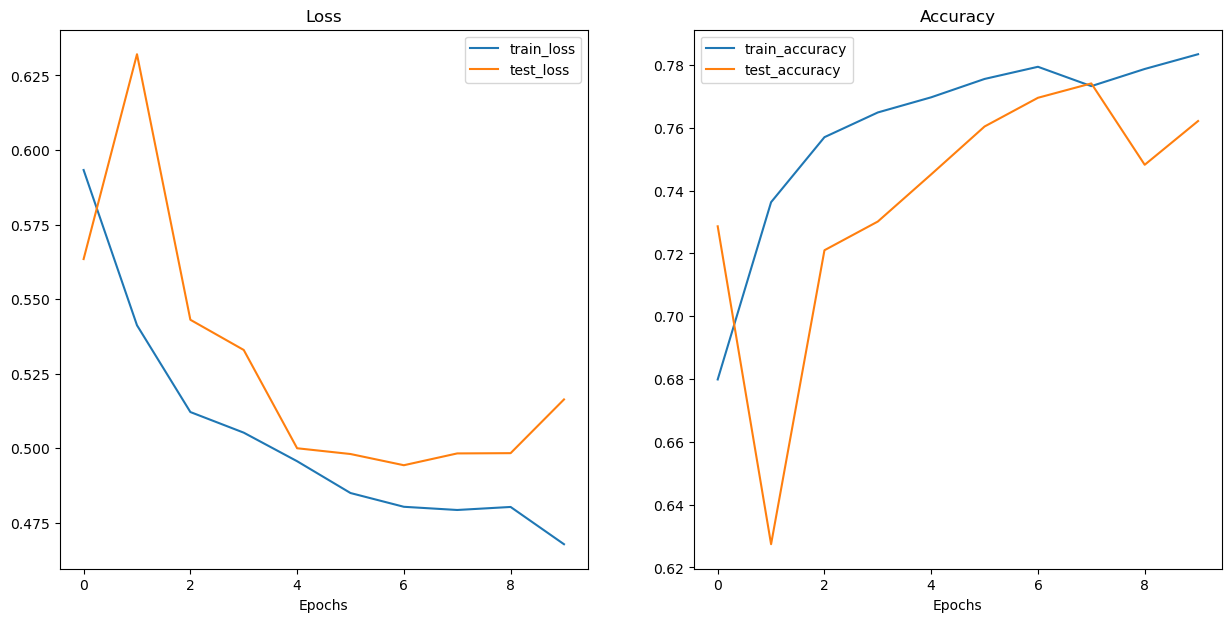

In [ ]:
plot_loss_curves(model_1_results)

In [ ]:
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)
MODEL_NAME = "TinyVGG_Model_PCam_twopercent_tenepochs.pth"
model_1_save_path = MODEL_PATH/MODEL_NAME
torch.save(model_1.state_dict(), model_1_save_path)